### Setup

ROOT: C:\Users\bigbo\Downloads\ai_for_conservation\invasive_plants_hawaii
Images dir exists? True
Metadata dir exists? True
               session      filename  \
0  session_1_1_16_2025  DSC00752.png   
1  session_1_1_16_2025  DSC00675.png   
2  session_1_1_16_2025  DSC00687.png   
3  session_1_1_16_2025  DSC00734.png   
4  session_1_1_16_2025  DSC00732.png   

                                          image_path  
0  invasive_plants_hawaii\images\session_1_1_16_2...  
1  invasive_plants_hawaii\images\session_1_1_16_2...  
2  invasive_plants_hawaii\images\session_1_1_16_2...  
3  invasive_plants_hawaii\images\session_1_1_16_2...  
4  invasive_plants_hawaii\images\session_1_1_16_2...  
Using path: invasive_plants_hawaii\images\session_1_1_16_2025\DSC00752.png
Exists? True
Original size: (6000, 4000) -> Display size: (512, 341)


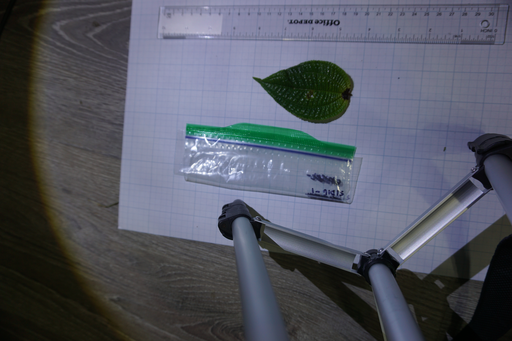


Label prevalence (dorsal):
healthy_label              0.191230
rust_label                 0.453106
leaf_miner_label           0.207065
other_insect_label         0.222899
mechanical_damage_label    0.185140
dtype: float64

any_damage prevalence (overall): 0.7618757612667478
Sizes:
  train: 1149
  val:   246
  test:  247

any_damage prevalence:
  train: 0.7615317667536988
  val:   0.7642276422764228
  test:  0.7611336032388664

pos_weight (train, per label):
  healthy_label: 4.394
  rust_label: 1.205
  leaf_miner_label: 3.828
  other_insect_label: 3.240
  mechanical_damage_label: 4.524


In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFile, UnidentifiedImageError
import numpy as np

# CONFIG 
ROOT = Path("./invasive_plants_hawaii")
METADATA_DIR = ROOT / "metadata"
IMAGES_DIR = ROOT / "images"

IMG_SIZE = 224 # change the image size
BATCH_SIZE = 32
NUM_EPOCHS = 5
RANDOM_STATE = 42

USE_YOLO = True # set True to enable YOLO+green cropping
YOLO_WEIGHTS = ROOT / "yolo11x_leaf.pt"
YOLO_CONF_THRESHOLD = 0.55
YOLO_MIN_GREEN = 0.0 # e.g. 0.5 if you want mostly-green boxes only
YOLO_PAD_RATIO = 0.05 # padding around bounding box

# Load metadata 
print("ROOT:", ROOT.resolve())
print("Images dir exists?", IMAGES_DIR.exists())
print("Metadata dir exists?", METADATA_DIR.exists())

dorsal_csv = METADATA_DIR / "full_dataset_dorsal.csv"
ventral_csv = METADATA_DIR / "full_dataset_ventral.csv"
both_csv   = METADATA_DIR / "full_dataset.csv"

df_dorsal  = pd.read_csv(dorsal_csv)
df_ventral = pd.read_csv(ventral_csv)
df_both    = pd.read_csv(both_csv)

def add_image_path(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        image_path=lambda d: d.apply(
            lambda row: IMAGES_DIR / row["session"] / row["filename"],
            axis=1,
        )
    )

df_dorsal  = add_image_path(df_dorsal)
df_ventral = add_image_path(df_ventral)
df_both    = add_image_path(df_both)

print(df_dorsal[["session", "filename", "image_path"]].head())

from IPython.display import display

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Quick sanity check image
path = df_dorsal["image_path"].iloc[0]
print("Using path:", path)
print("Exists?", path.exists())

try:
    img = Image.open(path)
    img.load()

    max_side = 512
    w, h = img.size
    scale = max_side / max(w, h)
    new_size = (int(w * scale), int(h * scale))

    img_small = img.resize(new_size, Image.LANCZOS)
    print("Original size:", (w, h), "-> Display size:", new_size)

    display(img_small)

except UnidentifiedImageError as e:
    print("Not a valid image (maybe Git LFS pointer):", e)
except Exception as e:
    print("Other error:", e)

# Label preprocessing 
BASE_LABEL_COLS = ["healthy", "rust", "leaf_miner", "other_insect", "mechanical_damage"]

def drop_expert_columns(df: pd.DataFrame) -> pd.DataFrame:
    expert_cols = [c for c in df.columns if c.startswith("expert_")]
    return df.drop(columns=expert_cols, errors="ignore")

def encode_yes_maybe_no(value):
    if isinstance(value, str):
        v = value.strip().lower()
        if v == "yes":
            return 1
        # everything else (no, maybe, blank, NaN) -> 0
    return 0

def add_binary_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in BASE_LABEL_COLS:
        new_col = f"{col}_label"
        df[new_col] = df[col].apply(encode_yes_maybe_no).astype("int64")
    return df

LABEL_COLS = [
    "healthy_label",
    "rust_label",
    "leaf_miner_label",
    "other_insect_label",
    "mechanical_damage_label",
]

df_dorsal_clean  = add_binary_labels(drop_expert_columns(df_dorsal))
df_ventral_clean = add_binary_labels(drop_expert_columns(df_ventral))
df_both_clean    = add_binary_labels(drop_expert_columns(df_both))

print("\nLabel prevalence (dorsal):")
print(df_dorsal_clean[LABEL_COLS].mean())

# Train/val/test splits 
from sklearn.model_selection import train_test_split

df = df_both_clean.copy()
damage_cols = ["rust_label", "leaf_miner_label", "other_insect_label", "mechanical_damage_label"]
df["any_damage"] = (df[damage_cols].sum(axis=1) > 0).astype(int)

print("\nany_damage prevalence (overall):", df["any_damage"].mean())

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=df["any_damage"],
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50, # half of 30% -> 15% total each
    random_state=RANDOM_STATE,
    stratify=temp_df["any_damage"],
)

print("Sizes:")
print("  train:", len(train_df))
print("  val:  ", len(val_df))
print("  test: ", len(test_df))

print("\nany_damage prevalence:")
print("  train:", train_df["any_damage"].mean())
print("  val:  ", val_df["any_damage"].mean())
print("  test: ", test_df["any_damage"].mean())

# Class imbalance: compute pos_weight on TRAIN ONLY 
# shape: [num_train, num_labels]
train_targets = train_df[LABEL_COLS].values.astype(np.float32)
num_pos = train_targets.sum(axis=0)
num_neg = train_targets.shape[0] - num_pos

pos_weight_np = num_neg / (num_pos + 1e-6)  # avoid divide-by-zero
print("\npos_weight (train, per label):")
for name, w in zip(LABEL_COLS, pos_weight_np):
    print(f"  {name}: {w:.3f}")

### YOLO crop

In [2]:
# Optional YOLO-based leaf cropping with green fraction, plus a simple cache.

import numpy as np
from PIL import Image

if USE_YOLO:
    import cv2
    from ultralytics import YOLO

    print("\n[YOLO] Loading model from:", YOLO_WEIGHTS)
    print("YOLO weights exist?", YOLO_WEIGHTS.exists())
    yolo_model = YOLO(str(YOLO_WEIGHTS))

    # cache: path string -> (x1p, y1p, x2p, y2p)
    crop_cache = {}

    def green_fraction(pil_img: Image.Image) -> float:
        """Compute fraction of 'green' pixels in a PIL RGB image using HSV thresholding."""
        arr = np.array(pil_img.convert("RGB"))
        hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV)

        lower_green = np.array([35, 40, 40])
        upper_green = np.array([85, 255, 255])

        mask = cv2.inRange(hsv, lower_green, upper_green)
        if mask.size == 0:
            return 0.0

        green_pixels = mask > 0
        return float(green_pixels.mean())

    def crop_with_yolo_most_green(pil_img: Image.Image, cache_key: str | None = None) -> Image.Image:
        """Run YOLO once per image (cached by path), crop to most-green box, else return original."""
        if cache_key is not None and cache_key in crop_cache:
            x1p, y1p, x2p, y2p = crop_cache[cache_key]
            return pil_img.crop((x1p, y1p, x2p, y2p))

        w, h = pil_img.size
        results = yolo_model(pil_img, verbose=False)
        if len(results) == 0 or results[0].boxes is None or len(results[0].boxes) == 0:
            return pil_img

        boxes = results[0].boxes
        best_crop = None
        best_green = -1.0
        best_coords = None

        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy()
            conf = float(box.conf.cpu().item())
            if conf < YOLO_CONF_THRESHOLD:
                continue

            x1, y1, x2, y2 = map(int, xyxy)
            bw = x2 - x1
            bh = y2 - y1
            pad_w = int(bw * YOLO_PAD_RATIO)
            pad_h = int(bh * YOLO_PAD_RATIO)

            x1p = max(0, x1 - pad_w)
            y1p = max(0, y1 - pad_h)
            x2p = min(w, x2 + pad_w)
            y2p = min(h, y2 + pad_h)

            crop = pil_img.crop((x1p, y1p, x2p, y2p))
            gf = green_fraction(crop)

            if gf >= YOLO_MIN_GREEN and gf > best_green:
                best_green = gf
                best_crop = crop
                best_coords = (x1p, y1p, x2p, y2p)

        if best_crop is None:
            return pil_img

        if cache_key is not None:
            crop_cache[cache_key] = best_coords
        return best_crop

else:
    def crop_with_yolo_most_green(pil_img: Image.Image, cache_key: str | None = None) -> Image.Image:
        """Identity function when YOLO is disabled."""
        return pil_img

print("USE_YOLO =", USE_YOLO)



[YOLO] Loading model from: invasive_plants_hawaii\yolo11x_leaf.pt
YOLO weights exist? True
USE_YOLO = True


### DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image

# Image transforms (ImageNet-ish)
train_transform = transforms.Compose([
    # Random crop + scale for mild geometric augmentation
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    # Slight color jitter (not too aggressive)
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.02,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class InvasivePlantsDataset(Dataset):
    def __init__(self, df, label_cols, transform=None, use_yolo: bool = False):
        self.df = df.reset_index(drop=True)
        self.label_cols = label_cols
        self.transform = transform
        self.use_yolo = use_yolo

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(row["image_path"])
        img = Image.open(img_path).convert("RGB")

        # Optional YOLO+green crop (defined in previous cell)
        if self.use_yolo and USE_YOLO:
            img = crop_with_yolo_most_green(img, cache_key=str(img_path))

        if self.transform is not None:
            img = self.transform(img)

        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return img, labels

# Device defined here 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = (device.type == "cuda")
print("Using device:", device)

train_dataset = InvasivePlantsDataset(train_df, LABEL_COLS, transform=train_transform, use_yolo=USE_YOLO)
val_dataset   = InvasivePlantsDataset(val_df,   LABEL_COLS, transform=eval_transform,  use_yolo=USE_YOLO)
test_dataset  = InvasivePlantsDataset(test_df,  LABEL_COLS, transform=eval_transform,  use_yolo=USE_YOLO)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=pin_memory,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
)

print("DataLoaders ready.")
print("Train/Val/Test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

Using device: cuda
DataLoaders ready.
Train/Val/Test sizes: 1149 246 247


### ResNet 

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

print("Training on device:", device)

# Small, fast ResNet
base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = base_model.fc.in_features

# New classifier head: one logit per damage type
base_model.fc = nn.Linear(num_features, len(LABEL_COLS))

# Freeze everything *except* layer4 and fc
for name, param in base_model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

model = base_model.to(device)

# Convert pos_weight_np (from Cell 1) to a tensor on the correct device
pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32, device=device)
print("Using pos_weight:", pos_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer over trainable params only
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate_acc(model, loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader, desc="Eval", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    acc = (all_preds == all_labels).float().mean().item()
    avg_loss = running_loss / len(loader.dataset)

    return avg_loss, acc

Training on device: cuda
Using pos_weight: tensor([4.3944, 1.2054, 3.8277, 3.2399, 4.5240], device='cuda:0')


In [5]:
NUM_EPOCHS = 5
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_acc(model, val_loader, criterion, device, threshold=0.5)

    print(
        f"Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f}  "
        f"val_loss={val_loss:.4f}  "
        f"val_acc@0.5={val_acc:.4f}"
    )

Epoch 01: train_loss=0.9056  val_loss=0.7931  val_acc@0.5=0.6959


Epoch 02: train_loss=0.6649  val_loss=0.7045  val_acc@0.5=0.7715


Epoch 03: train_loss=0.5674  val_loss=0.7115  val_acc@0.5=0.7951


Epoch 04: train_loss=0.4832  val_loss=0.6770  val_acc@0.5=0.8171


Epoch 05: train_loss=0.4219  val_loss=0.6532  val_acc@0.5=0.8057


### Val & Test Set

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
import torch

@torch.no_grad()
def collect_predictions(model, loader, device):
    """Run model on a DataLoader and collect probs + labels as NumPy arrays."""
    model.eval()
    all_probs = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    return all_probs, all_labels


def tune_thresholds_per_label(probs, labels, label_names):
    """
    For each label:
      - use val probs+labels
      - choose threshold that maximizes F1 on validation
    Returns: dict(label -> threshold), and per-label val metrics.
    """
    thresholds = {}
    per_label_results = []

    for j, name in enumerate(label_names):
        y_true = labels[:, j]
        y_score = probs[:, j]

        # If only one class present, AUROC/F1 aren't meaningful
        if len(np.unique(y_true)) < 2:
            thresholds[name] = 0.5
            per_label_results.append((name, np.nan, np.nan, 0.5))
            continue

        precision, recall, thr = precision_recall_curve(y_true, y_score)
        f1s = 2 * precision * recall / (precision + recall + 1e-8)

        if len(thr) == 0:
            thresholds[name] = 0.5
            per_label_results.append((name, np.nan, np.nan, 0.5))
            continue

        best_idx = int(np.nanargmax(f1s))
        if best_idx >= len(thr):
            best_idx = len(thr) - 1

        best_thr = thr[best_idx]
        y_pred_best = (y_score >= best_thr).astype(int)
        best_f1 = f1_score(y_true, y_pred_best, zero_division=0)
        auc = roc_auc_score(y_true, y_score)

        thresholds[name] = best_thr
        per_label_results.append((name, best_f1, auc, best_thr))

    return thresholds, per_label_results


def compute_metrics_with_thresholds(probs, labels, label_names, thresholds):
    """
    Apply fixed thresholds (tuned on val) to probs, compute F1 + AUROC on given labels.
    """
    per_label = []
    for j, name in enumerate(label_names):
        y_true = labels[:, j]
        y_score = probs[:, j]
        thr = thresholds.get(name, 0.5)
        y_pred = (y_score >= thr).astype(int)

        if len(np.unique(y_true)) < 2:
            f1 = np.nan
            auc = np.nan
        else:
            f1 = f1_score(y_true, y_pred, zero_division=0)
            auc = roc_auc_score(y_true, y_score)

        per_label.append((name, f1, auc, thr))
    return per_label


# 1) Collect predictions on val and test
val_probs,  val_labels  = collect_predictions(model, val_loader,  device)
test_probs, test_labels = collect_predictions(model, test_loader, device)

print("val_probs shape:",  val_probs.shape)
print("test_probs shape:", test_probs.shape)

# 2) Tune thresholds on validation set
val_thresholds, val_per_label = tune_thresholds_per_label(
    val_probs, val_labels, LABEL_COLS
)

val_df_metrics = pd.DataFrame(
    val_per_label, columns=["label", "val_f1", "val_auroc", "best_threshold"]
)
print("\nValidation metrics (per label):")
display(val_df_metrics)

print("\nMacro val F1   :", np.nanmean(val_df_metrics["val_f1"]))
print("Macro val AUROC:", np.nanmean(val_df_metrics["val_auroc"]))

# 3) Evaluate on test using those tuned thresholds
test_per_label = compute_metrics_with_thresholds(
    test_probs, test_labels, LABEL_COLS, val_thresholds
)

test_df_metrics = pd.DataFrame(
    test_per_label, columns=["label", "test_f1", "test_auroc", "threshold"]
)
print("\nTest metrics (per label):")
display(test_df_metrics)

print("\nMacro test F1   :", np.nanmean(test_df_metrics["test_f1"]))
print("Macro test AUROC:", np.nanmean(test_df_metrics["test_auroc"]))

val_probs shape: (246, 5)
test_probs shape: (247, 5)

Validation metrics (per label):


,label,val_f1,val_auroc,best_threshold
0,healthy_label,0.684685,0.906303,0.646593
1,rust_label,0.763359,0.839015,0.303099
2,leaf_miner_label,0.785047,0.935305,0.640920
3,other_insect_label,0.645833,0.888281,0.539564
4,mechanical_damage_label,0.596154,0.808160,0.679843



Macro val F1   : 0.6950154743539563
Macro val AUROC: 0.875412670982693

Test metrics (per label):


,label,test_f1,test_auroc,threshold
0,healthy_label,0.637931,0.901916,0.646593
1,rust_label,0.707317,0.814619,0.303099
2,leaf_miner_label,0.774775,0.928517,0.640920
3,other_insect_label,0.631579,0.890328,0.539564
4,mechanical_damage_label,0.363636,0.752679,0.679843



Macro test F1   : 0.6230476386866101
Macro test AUROC: 0.8576117532649203


### Save current run (config, metrics, thresholds, model weights)

In [7]:
import json
import pickle
from datetime import datetime
import numpy as np

# Root directory for saving runs
RUNS_DIR = ROOT / "resnet18_runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# Create a descriptive, timestamped run name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = (
    f"resnet18_"
    f"yolo{int(USE_YOLO)}_"
    f"img{IMG_SIZE}_"
    f"bs{BATCH_SIZE}_"
    f"seed{RANDOM_STATE}_"
    f"{timestamp}"
)
run_dir = RUNS_DIR / run_name
run_dir.mkdir(parents=True, exist_ok=True)

print("Saving run to:", run_dir)

# 1) Save config
config = {
    "IMG_SIZE": IMG_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "RANDOM_STATE": RANDOM_STATE,
    "USE_YOLO": USE_YOLO,
    "YOLO_WEIGHTS": str(YOLO_WEIGHTS),
    "YOLO_CONF_THRESHOLD": YOLO_CONF_THRESHOLD,
    "YOLO_MIN_GREEN": YOLO_MIN_GREEN,
    "YOLO_PAD_RATIO": YOLO_PAD_RATIO,
    "device": str(device),
    "num_train": len(train_dataset),
    "num_val": len(val_dataset),
    "num_test": len(test_dataset),
}

with open(run_dir / "config.json", "w") as f:
    json.dump(config, f, indent=2)

# 2) Save metrics DataFrames from Cell 6
val_df_metrics.to_csv(run_dir / "val_metrics.csv", index=False)
test_df_metrics.to_csv(run_dir / "test_metrics.csv", index=False)

# 3) Save thresholds
with open(run_dir / "val_thresholds.pkl", "wb") as f:
    pickle.dump(val_thresholds, f)

# 4) Save model weights
torch.save(model.state_dict(), run_dir / "model_state_dict.pt")

# 5) Simple text summary
macro_val_f1   = float(np.nanmean(val_df_metrics["val_f1"]))
macro_val_auc  = float(np.nanmean(val_df_metrics["val_auroc"]))
macro_test_f1  = float(np.nanmean(test_df_metrics["test_f1"]))
macro_test_auc = float(np.nanmean(test_df_metrics["test_auroc"]))

with open(run_dir / "summary.txt", "w") as f:
    f.write("ResNet-18 baseline run summary\n")
    f.write(f"Run name       : {run_name}\n")
    f.write(f"Device         : {device}\n")
    f.write(f"USE_YOLO       : {USE_YOLO}\n")
    f.write(f"IMG_SIZE       : {IMG_SIZE}\n")
    f.write(f"BATCH_SIZE     : {BATCH_SIZE}\n")
    f.write(f"NUM_EPOCHS     : {NUM_EPOCHS}\n")
    f.write("\n")
    f.write(f"Macro val F1   : {macro_val_f1:.4f}\n")
    f.write(f"Macro val AUROC: {macro_val_auc:.4f}\n")
    f.write(f"Macro test F1  : {macro_test_f1:.4f}\n")
    f.write(f"Macro test AUROC: {macro_test_auc:.4f}\n")

print("Saved config.json, val_metrics.csv, test_metrics.csv, val_thresholds.pkl, model_state_dict.pt, and summary.txt.")

Saving run to: invasive_plants_hawaii\resnet18_runs\resnet18_yolo1_img224_bs32_seed42_20251204_105616
Saved config.json, val_metrics.csv, test_metrics.csv, val_thresholds.pkl, model_state_dict.pt, and summary.txt.
